In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
df_fpt= pd.read_csv('dataset/excel_fpt.csv')
columns = [i.replace('<', '').replace('>', '') for i in df_fpt.columns]
columns[1] = 'DateTime'
df_fpt.rename(columns = {df_fpt.columns[i]: columns[i] for i in range(len(df_fpt.columns))}, inplace = True)
df_fpt['DateTime'] = pd.to_datetime(df_fpt['DateTime'], format='%Y%m%d', errors='ignore')
df_fpt = df_fpt.set_index('DateTime')
df_fpt = df_fpt.sort_index()
df_fpt.head()

,Ticker,Open,High,Low,Close,Volume
DateTime,,,,,,
2006-12-13,FPT,22.5807,22.5807,22.5807,22.5807,83530
2006-12-14,FPT,23.7097,23.7097,23.7097,23.7097,280710
2006-12-15,FPT,24.8952,24.8952,24.8952,24.8952,265300
2006-12-18,FPT,26.1371,26.1371,26.1371,26.1372,215790
2006-12-19,FPT,27.4356,27.4356,27.4356,27.4356,137520


# CLOSE DIFF

In [ ]:
df = df_fpt.copy()
df['Close_diff_1'] = df['Close']-df.shift()['Close']
df['Close_diff_3'] = df['Close']-df.shift(2)['Close']
df['Close_diff_4'] = df['Close']-df.shift(3)['Close']
df['Close_diff_5'] = df['Close']-df.shift(4)['Close']
df['Close_diff_6'] = df['Close']-df.shift(5)['Close']
df['Close_diff_7'] = df['Close']-df.shift(6)['Close']

df.head()

In [ ]:
df = df[['Close_diff_1','Close_diff_3','Close_diff_4','Close_diff_5','Close_diff_6','Close_diff_7']]
df = df.dropna()
y_train = df[['Close_diff_1']]['2007-01-01':'2017-01-01'].to_numpy()
y_test = df[['Close_diff_1']]['2017-01-01':].to_numpy()
x_train = df[['Close_diff_3','Close_diff_4','Close_diff_5','Close_diff_6','Close_diff_7']]['2007-01-01':'2017-01-01'].to_numpy()
x_test = df[['Close_diff_3','Close_diff_4','Close_diff_5','Close_diff_6','Close_diff_7']]['2017-01-01':].to_numpy()
# print(x_train)

print("Train: {}\t Test: {}".format(len(x_train), len(x_test)))
print("Shape:", x_train.shape, y_train.shape)

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
test_X = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print("Shape:", train_X.shape, y_train.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


In [ ]:
model.summary()

In [ ]:
history = model.fit(train_X, y_train, epochs=50, batch_size=72, verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = model.predict(test_X)
rmse = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)

# Single LSTM 

In [18]:
df_fpt = df_fpt.sort_values('DateTime')
df_fpt.reset_index(inplace=True)
print(df_fpt.head())
close_prices = df_fpt.iloc[:, 4:5].values
print(close_prices.shape)

    DateTime Ticker     Open     High      Low    Close  Volume
0 2006-12-13    FPT  22.5807  22.5807  22.5807  22.5807   83530
1 2006-12-14    FPT  23.7097  23.7097  23.7097  23.7097  280710
2 2006-12-15    FPT  24.8952  24.8952  24.8952  24.8952  265300
3 2006-12-18    FPT  26.1371  26.1371  26.1371  26.1372  215790
4 2006-12-19    FPT  27.4356  27.4356  27.4356  27.4356  137520
(3490, 1)


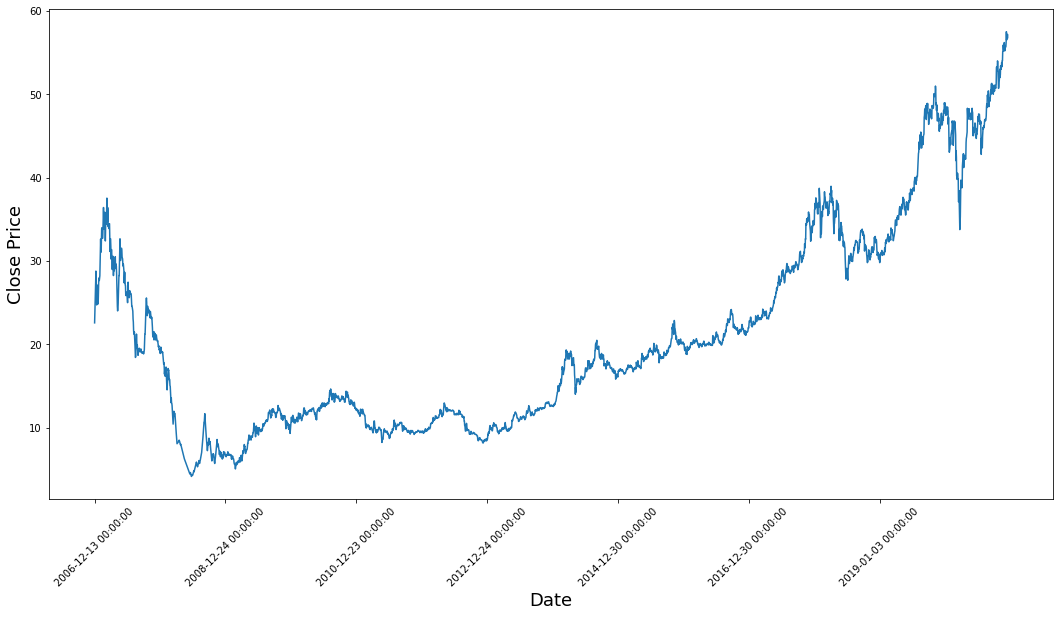

In [19]:
plt.figure(figsize = (18,9))
plt.plot(range(df_fpt.shape[0]),(df_fpt['Close']))
plt.xticks(range(0,df_fpt.shape[0],500),df_fpt['DateTime'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

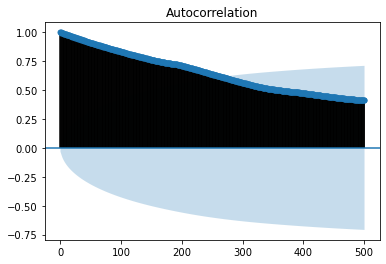

In [20]:
import statsmodels.api as sm
tmp = sm.graphics.tsa.plot_acf(df_fpt['Close'], lags=500)

In [21]:
X_train = []
y_train = []
timestamp = 20
for i in range(timestamp, len(close_prices)-500):
    X_train.append(close_prices[i-timestamp:i, 0])
    y_train.append(close_prices[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)
print(X_train, y_train)

(2970, 20) (2970,)
[[22.5807 23.7097 24.8952 ... 27.6613 27.6614 27.6614]
 [23.7097 24.8952 26.1371 ... 27.6614 27.6614 28.2259]
 [24.8952 26.1371 27.4356 ... 27.6614 28.2259 29.6372]
 ...
 [30.4589 30.8606 31.2623 ... 32.2849 32.0658 32.1754]
 [30.8606 31.2623 31.2989 ... 32.0658 32.1754 32.504 ]
 [31.2623 31.2989 31.1893 ... 32.1754 32.504  32.2119]] [28.2259 29.6372 30.2017 ... 32.504  32.2119 31.4084]


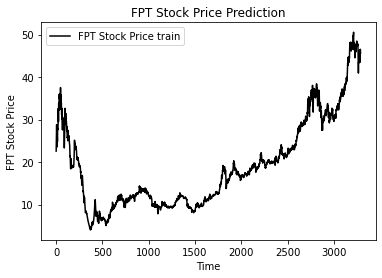

In [22]:
plt.plot(close_prices[:-200], color = 'black', label = 'FPT Stock Price train')
# plt.plot(predicted_stock_price, color = 'green', label = 'Predicted FPT Stock Price')
plt.title('FPT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()


In [23]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
sc.fit(X_train)
x_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train.reshape(-1,1))
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# model.fit(x_train, y_train, epochs = 25, batch_size = 32)



In [147]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
model.load_weights('model.h5')


In [39]:
test = close_prices[len(close_prices)-500:].reshape(-1,1)
# print(len(test))
inputs = sc.fit_transform(test)
# print(np.array([inputs[i-7:i, 0]]).shape)
# X_test = np.array([inputs[:7, 0]]).reshape(1,7,1)
# print(X_test.shape)
# predicted_stock_price = []
# k = 1
# for i in range(7,100):
#     y_pred = model.predict(X_test)
#     predicted_stock_price.append(y_pred)
#     print("GT:",inputs[k:k+7])
#     X_test = np.concatenate((X_test[0,1:,0],y_pred[0])).reshape(1,7,1)
#     print("Pred:",X_test[0,:,0])
#     k += 1
# print(X_test.shape)
X_test = []
for i in range(timestamp, len(inputs)):
    X_test.append(inputs[i-timestamp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(480, 20, 1)


In [40]:
# print(len(predicted_stock_price))
# predicted_stock_price = np.array(predicted_stock_price).reshape(993,1)
# print(np.array(predicted_stock_price).shape)

In [41]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# predicted_stock_price = np.insert(predicted_stock_price, 0,0)
# print(test[:60].shape,predicted_stock_price.shape)
predicted_stock_price = np.concatenate((test[:timestamp],predicted_stock_price))
len(predicted_stock_price)
# print(predicted_stock_price)

500

500
500


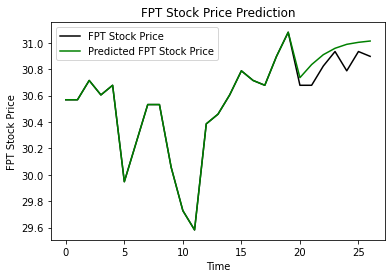

In [42]:
real_stock_price = test
print(len(predicted_stock_price))
print(len(real_stock_price))
plt.plot(real_stock_price[:27], color = 'black', label = 'FPT Stock Price')
plt.plot(predicted_stock_price[:27], color = 'green', label = 'Predicted FPT Stock Price')
plt.title('FPT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()


In [43]:
# predict 7 ngay dau tien cua 30 ngay test
def MAPE(y_true, y_pred):
    error = np.abs(y_true - y_pred) / y_true
#     error.replace([np.inf, -np.inf], np.nan, inplace=True)
    error = error[~np.isnan(error)]

    return np.mean(error) * 100
MAPE(real_stock_price,predicted_stock_price)

2.458837422848151

# Multi Step Forecasting LSTM

In [90]:
df_fpt= pd.read_csv('dataset/excel_fpt.csv')
columns = [i.replace('<', '').replace('>', '') for i in df_fpt.columns]
columns[1] = 'DateTime'
df_fpt.rename(columns = {df_fpt.columns[i]: columns[i] for i in range(len(df_fpt.columns))}, inplace = True)
df_fpt['DateTime'] = pd.to_datetime(df_fpt['DateTime'], format='%Y%m%d', errors='ignore')
df_fpt = df_fpt.set_index('DateTime')
df_fpt = df_fpt.sort_index()
df_fpt.head()

,Ticker,Open,High,Low,Close,Volume
DateTime,,,,,,
2006-12-13,FPT,22.5807,22.5807,22.5807,22.5807,83530
2006-12-14,FPT,23.7097,23.7097,23.7097,23.7097,280710
2006-12-15,FPT,24.8952,24.8952,24.8952,24.8952,265300
2006-12-18,FPT,26.1371,26.1371,26.1371,26.1372,215790
2006-12-19,FPT,27.4356,27.4356,27.4356,27.4356,137520


In [91]:
df_fpt = df_fpt.sort_values('DateTime')
# df_fpt.reset_index(inplace=True)
close_prices = df_fpt.iloc[:, 4:5]
print(close_prices)

              Close
DateTime           
2006-12-13  22.5807
2006-12-14  23.7097
2006-12-15  24.8952
2006-12-18  26.1372
2006-12-19  27.4356
...             ...
2020-12-10  56.5000
2020-12-11  57.0000
2020-12-14  57.2000
2020-12-15  56.7000
2020-12-16  57.1000

[3490 rows x 1 columns]


In [92]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [93]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	print(supervised)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test


In [94]:
n_lag = 60
n_seq = 30
n_test = 200
train, test = prepare_data(close_prices, n_test, n_lag, n_seq)
print(train)
print('Train: %s, Test: %s' % (train.shape, test.shape))

      var1(t-60)  var1(t-59)  var1(t-58)  var1(t-57)  var1(t-56)  var1(t-55)  \
60       22.5807     23.7097     24.8952     26.1372     27.4356     28.7904   
61       23.7097     24.8952     26.1372     27.4356     28.7904     27.3791   
62       24.8952     26.1372     27.4356     28.7904     27.3791     26.0243   
63       26.1372     27.4356     28.7904     27.3791     26.0243     24.7259   
64       27.4356     28.7904     27.3791     26.0243     24.7259     25.9114   
...          ...         ...         ...         ...         ...         ...   
3456     45.8195     46.1132     46.2111     46.0153     46.5048     46.9454   
3457     46.1132     46.2111     46.0153     46.5048     46.9454     46.7985   
3458     46.2111     46.0153     46.5048     46.9454     46.7985     47.0000   
3459     46.0153     46.5048     46.9454     46.7985     47.0000     46.8500   
3460     46.5048     46.9454     46.7985     47.0000     46.8500     46.8500   

      var1(t-54)  var1(t-53)  var1(t-52

In [95]:
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

In [96]:
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [97]:
forecasts = make_forecasts(train, test, n_lag, n_seq)
print(forecasts)

[[48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376, 48.1376], [47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704, 47.9704], [46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826, 46.3826], [47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47.2183, 47

In [98]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = np.sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [99]:
evaluate_forecasts(test, forecasts, n_lag, n_seq)


t+1 RMSE: 0.887710
t+2 RMSE: 1.240117
t+3 RMSE: 1.514235
t+4 RMSE: 1.760486
t+5 RMSE: 1.950399
t+6 RMSE: 2.129247
t+7 RMSE: 2.295124
t+8 RMSE: 2.444270
t+9 RMSE: 2.580980
t+10 RMSE: 2.702023
t+11 RMSE: 2.830778
t+12 RMSE: 2.960656
t+13 RMSE: 3.074414
t+14 RMSE: 3.212773
t+15 RMSE: 3.337330
t+16 RMSE: 3.473135
t+17 RMSE: 3.601577
t+18 RMSE: 3.712239
t+19 RMSE: 3.795772
t+20 RMSE: 3.882153
t+21 RMSE: 3.981587
t+22 RMSE: 4.057324
t+23 RMSE: 4.124984
t+24 RMSE: 4.196964
t+25 RMSE: 4.274138
t+26 RMSE: 4.349328
t+27 RMSE: 4.434112
t+28 RMSE: 4.523591
t+29 RMSE: 4.591565
t+30 RMSE: 4.647519


In [100]:
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	plt.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		plt.plot(xaxis, yaxis, color='red')
	# show the plot
	plt.show()


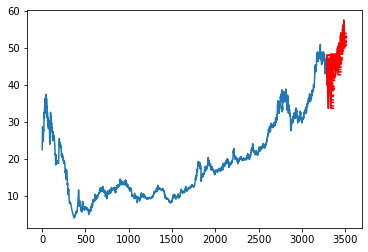

In [101]:
plot_forecasts(close_prices, forecasts, n_test+2)

In [104]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [105]:
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	print(supervised)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [106]:
scaler, train, test = prepare_data(close_prices, n_test, n_lag, n_seq)


      var1(t-60)  var1(t-59)  var1(t-58)  var1(t-57)  var1(t-56)  var1(t-55)  \
60      0.420108    0.439116    0.458124    0.477098    0.496072   -0.434507   
61      0.439116    0.458124    0.477098    0.496072   -0.434507   -0.415499   
62      0.458124    0.477098    0.496072   -0.434507   -0.415499   -0.396525   
63      0.477098    0.496072   -0.434507   -0.415499   -0.396525    0.439116   
64      0.496072   -0.434507   -0.415499   -0.396525    0.439116    0.439116   
...          ...         ...         ...         ...         ...         ...   
3455   -0.025585    0.139094    0.073222   -0.025585    0.204966    0.188515   
3456    0.139094    0.073222   -0.025585    0.204966    0.188515   -0.009134   
3457    0.073222   -0.025585    0.204966    0.188515   -0.009134    0.108076   
3458   -0.025585    0.204966    0.188515   -0.009134    0.108076   -0.010177   
3459    0.204966    0.188515   -0.009134    0.108076   -0.010177    0.040287   

      var1(t-54)  var1(t-53)  var1(t-52

In [256]:
def lstm(X,y,n_batch,n_neurons):
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [107]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
    
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
		model.reset_states()
	return model


In [267]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [265]:
!pip install pydot
!pip install graphviz

In [108]:
model = fit_lstm(train, n_lag, n_seq, 1, 150, 1)

3200/3200 [==============================] - 5s 1ms/step - loss: 0.0146


In [212]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [213]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [214]:
forecasts = make_forecasts(model, 1, train, test, n_lag, n_seq)
print(len(forecasts))

200


In [215]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [216]:
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [217]:
forecasts = inverse_transform(close_prices, forecasts, scaler, n_test+2)


In [218]:
actual = [row[n_lag:] for row in test]
actual = inverse_transform(close_prices, actual, scaler, n_test+2)
print(np.asarray(actual))

[[[46.5497]
  [44.9619]
  [45.7976]
  ...
  [44.9619]
  [44.2097]
  [43.7083]]

 [[44.7948]
  [45.6305]
  [44.1262]
  ...
  [44.0426]
  [43.5412]
  [40.449 ]]

 [[46.4661]
  [44.9618]
  [42.7053]
  ...
  [44.3768]
  [41.2846]
  [42.4546]]

 ...

 [[58.6   ]
  [58.8   ]
  [57.8   ]
  ...
  [62.3   ]
  [62.8   ]
  [63.    ]]

 [[56.7   ]
  [55.7   ]
  [56.1   ]
  ...
  [60.7   ]
  [60.9   ]
  [60.4   ]]

 [[56.    ]
  [56.4   ]
  [57.4   ]
  ...
  [61.2   ]
  [60.7   ]
  [61.1   ]]]


In [219]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	total_error = []
	for i in range(n_seq):
		actual = np.asarray([row[i] for row in test])
		predicted = np.asarray([forecast[i] for forecast in forecasts])
# 		print(actual[:30],predicted[:30])
		error = np.abs(actual - predicted)/actual
# 		error.replace([np.inf, -np.inf], np.nan, inplace=True)
		error = error[~np.isnan(error)].mean()*100
		total_error.append(error)
		print('t+%d MAPE: %f' % ((i+1), error))
	print('Total:',np.array(total_error).mean())

In [220]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	plt.plot(np.concatenate((series.values[:len(series.values)-n_test],forecasts)))
	plt.plot(series.values)
	# plot the forecasts in red
# 	for i in range(len(forecasts)):
# 		off_s = len(series) - n_test + i - 1
# 		off_e = off_s + len(forecasts[i]) + 1
# 		xaxis = [x for x in range(off_s, off_e)]
# 		yaxis = [series.values[off_s]] + forecasts[i]
# 		plt.plot(xaxis, yaxis, color='red')
	# show the plot
	plt.show()

In [221]:
def MAPE(y_true, y_pred):
    error = np.abs(y_true - y_pred) / y_true
    error.replace([np.inf, -np.inf], np.nan, inplace=True)
    error = error[~np.isnan(error)]


In [254]:
# evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
# plot_forecasts(close_prices, np.asarray(forecasts)[:,2], n_test+2)
# h = np.array(forecasts[0])
# print(h)
# for i in range(1,30):    
#     tmp = abs((h[i]-h[i-1])/h[i-1])*100
#     print(tmp)
# forecasts = np.asarray(forecasts)
# df_forecasts[:] = df_forecasts[:].T
h = np.array(forecasts[0])
print(h.shape)
print(np.asarray(actual).shape)
# print(actual[0])
k = np.asarray(actual[0])
ff = np.concatenate((h,k),axis=1)
print(ff.shape)
df_forecasts = pd.DataFrame(ff)
df_forecasts.head()

(30, 1)
(200, 30, 1)
(30, 2)


,0,1
0,46.939651,46.5497
1,47.100679,44.9619
2,47.235448,45.7976
3,47.309396,44.2933
4,47.394369,42.0368


# Test class model

In [24]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

class lstm():
    """A class for an building and inferencing an lstm model"""
    
    def __init__(self, input_shape):
        self.model = Sequential()
        
        self.model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units = 50, return_sequences = True))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units = 50, return_sequences = True))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units = 50))
        self.model.add(Dropout(0.2))

        self.model.add(Dense(units = 1))

        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    def load_model_weights(self, filepath):
        print('[Model] Loading model from file %s' % filepath)
        self.model.load_weights(filepath)
    
    def predict(self,data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        print('[Model] Predicting...')
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted


In [25]:
model = lstm((x_train.shape[1], 1))

In [26]:
model.load_model_weights('model.h5')

[Model] Loading model from file model.h5


In [31]:
y_pred = model.predict(X_test).reshape(-1,1)

[Model] Predicting...


In [32]:
predicted_stock_price = sc.inverse_transform(y_pred)
# predicted_stock_price = np.insert(predicted_stock_price, 0,0)
# print(test[:60].shape,predicted_stock_price.shape)
predicted_stock_price = np.concatenate((test[:timestamp],predicted_stock_price))
len(predicted_stock_price)
# print(predicted_stock_price)

500

In [33]:
# predict 7 ngay dau tien cua 30 ngay test
def MAPE(y_true, y_pred):
    error = np.abs(y_true - y_pred) / y_true
    error.replace([np.inf, -np.inf], np.nan, inplace=True)
    error = error[~np.isnan(error)]

    return np.mean(error) * 100
MAPE(real_stock_price,predicted_stock_price)

NameError: name 'real_stock_price' is not defined